In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

/home/boris/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/boris/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
df = pd.read_csv('data/declarations.csv')
common_offices = pd.read_csv('data/common_offices.csv', converters={"person_id": eval})

In [12]:
df.head()

,person_id,person_name,year,office_id,office_name,income,savings,real_estate_amount,real_estate_squares
0,8,Зюганов Геннадий Андреевич,1998,14,Государственная Дума,124154.00,0.00,1,150.0
1,8,Зюганов Геннадий Андреевич,1999,449,Президент Российской Федерации,506247.00,0.00,3,252.7
2,8,Зюганов Геннадий Андреевич,2006,14,Государственная Дума,1257784.00,141740.91,1,167.4
3,8,Зюганов Геннадий Андреевич,2006,449,Президент Российской Федерации,3590668.48,400490.32,2,281.3
4,8,Зюганов Геннадий Андреевич,2009,14,Государственная Дума,2177821.52,0.00,3,448.7


In [8]:
office_names = df[['office_id', 'office_name']].drop_duplicates().reset_index(drop=True)
office_names.head()

,office_id,office_name
0,14,Государственная Дума
1,449,Президент Российской Федерации
2,118,Государственное собрание – Курултай Республик...
3,267,Законодательное собрание Алтайского края
4,211,Губернатор Иркутской области


In [9]:
person_names = df[['person_id', 'person_name']].drop_duplicates().reset_index(drop=True)
person_names.head()

,person_id,person_name
0,8,Зюганов Геннадий Андреевич
1,9,Алферов Жорес Иванович
2,10,Андреев Андрей Анатольевич
3,11,Апарина Алевтина Викторовна
4,12,Афонин Юрий Вячеславович


In [10]:
person_offices = df[['year', 'person_id', 'office_id', 'office_name']].drop_duplicates().reset_index(drop=True)
person_offices.head()

,year,person_id,office_id,office_name
0,1998,8,14,Государственная Дума
1,1999,8,449,Президент Российской Федерации
2,2006,8,14,Государственная Дума
3,2006,8,449,Президент Российской Федерации
4,2009,8,14,Государственная Дума


In [11]:
common_offices.year.value_counts()

2017    1730
2014    1630
2015    1507
2016    1454
2013     648
2012     558
2011     398
2010     300
2009     226
2018      81
2008      30
2006       2
1999       1
1998       1
Name: year, dtype: int64

In [8]:
YEAR = 2009

year_offices = common_offices[common_offices.year == YEAR]
year_offices.head()

,year,office_id,person_id
34,2009,1,"[9133, 9161]"
35,2009,3,"[679, 680, 681, 682, 7298, 7299, 7300, 7301, 7..."
36,2009,4,[5350]
37,2009,5,"[80, 299]"
38,2009,7,"[1882, 19701]"


In [102]:
graph = nx.Graph()

edge_properties = year_offices[['year', 'office_id']]
edge_lists = year_offices.person_id
for year, office_id, nodes_to_connect in year_offices.values[:8]:
    combs = list(itertools.permutations(nodes_to_connect,2))
    graph.add_edges_from(combs)

In [103]:
print(graph.order())
print(graph.size())

263
26292


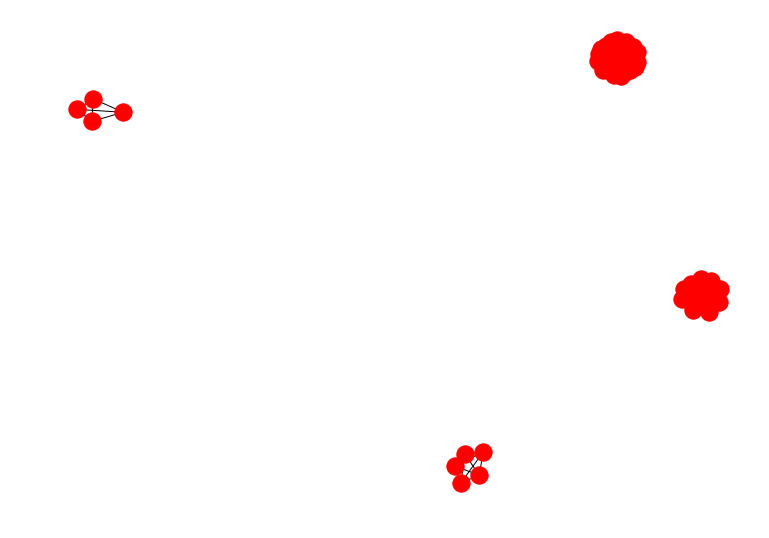

In [99]:
plt.figure(figsize=(10, 7))
nx.draw(graph)    
plt.show()

In [ ]:
centrality = nx.eigenvector_centrality(graph)
centrality_series = pd.Series(centrality)
print(centrality_series.describe())

In [57]:
top_centrality_nodes = centrality_series.nlargest(10)
top_centrality_ids = np.array(top_centrality_nodes.index)
top_centrality_names = person_names[person_names.person_id.isin(top_centrality_ids)]
top_centrality_names

,person_id,person_name
643,679,Чуров Владимир Евгеньевич
644,680,Ивлев Леонид Григорьевич
645,681,Вавилов Станислав Владимирович
646,682,Конкин Николай Евгеньевич
6999,7298,Борисов Игорь Борисович
7000,7299,Волков Василий Петрович
7001,7300,Гришина Майя Владимировна
7002,7301,Демьянченко Людмила Федоровна
7003,7302,Дубровина Елена Павловна
7004,7303,Ермакова Эльвира Леонидовна


In [58]:
top_centrality_names.merge(person_offices[person_offices.year == YEAR], how='left', on='person_id').drop(['year'], axis=1)
def draw_centralities(graph, measures, pos=None, k_mult=1.5, size_mult=5000):    
    
    plt.axis('off')
    pos = pos or nx.spring_layout(graph, k=k_mult/np.sqrt(graph.order()))
    nx.draw_networkx(graph,
                     pos=pos,
                     #node_size = [d*size_mult for k, d in measures.items()],
                     #node_color=measures.values(),
                     font_size=14,
                     cmap=plt.cm.Reds,
                     with_labels=False,
                     edge_color='grey',
                     alpha=0.8)
    
    
def get_top_subgraph(graph, measures, quantile=0.5):
    dcs = pd.Series(measures)
    mask = dcs > dcs.quantile(quantile)
    nodes = pd.Series(graph.nodes())
    nodes.index = mask.index
    subgraph_nodes = nodes.loc[mask]
    subgraph_dcs = dcs.loc[mask]
    subgraph_top = nx.subgraph(graph, subgraph_nodes)
    
    subgraph_measures = {k:v for k,v in measures.items() if k in subgraph_nodes}
    return subgraph_top, subgraph_measures

subgraph, subgraph_centralities = get_top_subgraph(graph, centrality_series,
                                                   quantile=0.1)
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph)
plt.show()

,person_id,person_name,office_id,office_name
0,679,Чуров Владимир Евгеньевич,3,Центральная избирательная комиссия
1,680,Ивлев Леонид Григорьевич,3,Центральная избирательная комиссия
2,681,Вавилов Станислав Владимирович,3,Центральная избирательная комиссия
3,682,Конкин Николай Евгеньевич,3,Центральная избирательная комиссия
4,7298,Борисов Игорь Борисович,3,Центральная избирательная комиссия
5,7299,Волков Василий Петрович,3,Центральная избирательная комиссия
6,7300,Гришина Майя Владимировна,3,Центральная избирательная комиссия
7,7301,Демьянченко Людмила Федоровна,3,Центральная избирательная комиссия
8,7302,Дубровина Елена Павловна,3,Центральная избирательная комиссия
9,7303,Ермакова Эльвира Леонидовна,3,Центральная избирательная комиссия


In [1]:
joined = df[['year', 'person_id', 'office_id']].merge(df[['year', 'person_id', 'office_id']], on=['office_id', 'year'], how='inner')

NameError: name 'df' is not defined

In [1]:
person_dict = {}
for year, office, persons in common_offices.values:
    pass    

NameError: name 'common_offices' is not defined